# Sanity Check of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_centercrop_showcase.ipynb`, with `centercrop_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:1")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=1)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

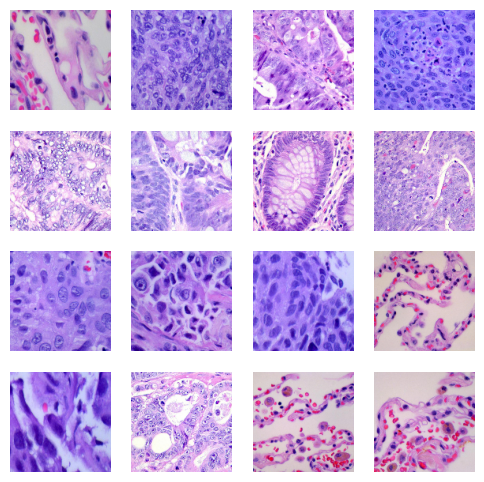

| It: 1 | Loss: -16.6231 | Time:   5.06s |


| It: 1001 | Loss: -61.1770 | Time: 466.55s |


| It: 2001 | Loss: -61.5977 | Time: 466.99s |


| It: 3001 | Loss: -61.7181 | Time: 464.64s |


| It: 4001 | Loss: -61.7772 | Time: 464.49s |


| It: 5001 | Loss: -61.8230 | Time: 463.41s |


| It: 6001 | Loss: -61.8548 | Time: 467.48s |


| It: 7001 | Loss: -61.8806 | Time: 466.54s |


| It: 8001 | Loss: -61.8969 | Time: 467.79s |


| It: 9001 | Loss: -61.9045 | Time: 465.42s |


| It: 1 | Loss: -18.1215 | Time:   0.51s |


| It: 1001 | Loss: -60.9592 | Time: 467.56s |


| It: 2001 | Loss: -61.5219 | Time: 467.77s |


| It: 3001 | Loss: -61.6716 | Time: 467.04s |


| It: 4001 | Loss: -61.7512 | Time: 468.43s |


| It: 5001 | Loss: -61.8026 | Time: 467.33s |


| It: 6001 | Loss: -61.8405 | Time: 467.58s |


| It: 7001 | Loss: -61.8670 | Time: 465.68s |


| It: 8001 | Loss: -61.8854 | Time: 466.88s |


| It: 9001 | Loss: -61.8937 | Time: 466.45s |


| It: 1 | Loss: -25.6572 | Time:   0.37s |


| It: 1001 | Loss: -61.1409 | Time: 464.75s |


| It: 2001 | Loss: -61.5882 | Time: 466.47s |


| It: 3001 | Loss: -61.7139 | Time: 462.52s |


| It: 4001 | Loss: -61.7782 | Time: 465.46s |


| It: 5001 | Loss: -61.8206 | Time: 466.24s |


| It: 6001 | Loss: -61.8533 | Time: 466.37s |


| It: 7001 | Loss: -61.8783 | Time: 543.98s |


| It: 8001 | Loss: -61.8949 | Time: 563.19s |


| It: 9001 | Loss: -61.9028 | Time: 560.84s |


| It: 1 | Loss: -31.7349 | Time:   0.55s |


| It: 1001 | Loss: -61.0837 | Time: 560.97s |


| It: 2001 | Loss: -61.5745 | Time: 563.63s |


| It: 3001 | Loss: -61.7110 | Time: 561.11s |


| It: 4001 | Loss: -61.7733 | Time: 560.09s |


| It: 5001 | Loss: -61.8188 | Time: 562.23s |


| It: 6001 | Loss: -61.8538 | Time: 562.34s |


| It: 7001 | Loss: -61.8785 | Time: 561.10s |


| It: 8001 | Loss: -61.8938 | Time: 560.41s |


| It: 9001 | Loss: -61.9017 | Time: 554.41s |


| It: 1 | Loss: -17.9783 | Time:   0.57s |


| It: 1001 | Loss: -60.9969 | Time: 561.08s |


| It: 2001 | Loss: -61.5540 | Time: 561.40s |


| It: 3001 | Loss: -61.6976 | Time: 561.13s |


| It: 4001 | Loss: -61.7658 | Time: 560.33s |


| It: 5001 | Loss: -61.8076 | Time: 561.42s |


| It: 6001 | Loss: -61.8478 | Time: 562.30s |


| It: 7001 | Loss: -61.8726 | Time: 561.51s |


| It: 8001 | Loss: -61.8892 | Time: 563.18s |


| It: 9001 | Loss: -61.8978 | Time: 563.14s |


BEST PSNR: 13.6564
MEDIAN PSNR: 13.4088
ALL PSNR: [13.2424, 13.3453, 13.2920, 13.5076, 13.5076]


<Figure size 400x300 with 0 Axes>

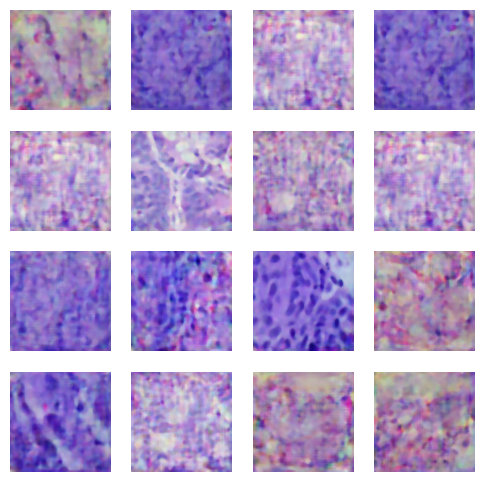

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

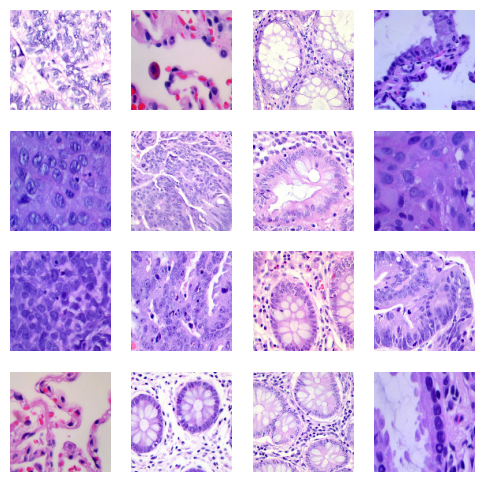

| It: 1 | Loss: -28.9044 | Time:   0.60s |


| It: 1001 | Loss: -60.7516 | Time: 560.27s |


| It: 2001 | Loss: -61.4516 | Time: 561.64s |


| It: 3001 | Loss: -61.6213 | Time: 562.19s |


| It: 4001 | Loss: -61.7127 | Time: 561.73s |


| It: 5001 | Loss: -61.7732 | Time: 560.54s |


| It: 6001 | Loss: -61.8166 | Time: 562.24s |


| It: 7001 | Loss: -61.8501 | Time: 560.10s |


| It: 8001 | Loss: -61.8706 | Time: 561.10s |


| It: 9001 | Loss: -61.8814 | Time: 560.56s |


| It: 1 | Loss: -19.1915 | Time:   0.47s |


| It: 1001 | Loss: -61.0052 | Time: 557.52s |


| It: 2001 | Loss: -61.4834 | Time: 562.20s |


| It: 3001 | Loss: -61.6594 | Time: 560.31s |


| It: 4001 | Loss: -61.7351 | Time: 559.43s |


| It: 5001 | Loss: -61.7881 | Time: 562.22s |


| It: 6001 | Loss: -61.8273 | Time: 558.74s |


| It: 7001 | Loss: -61.8599 | Time: 561.36s |


| It: 8001 | Loss: -61.8798 | Time: 382.91s |


| It: 9001 | Loss: -61.8898 | Time: 350.99s |


| It: 1 | Loss: -17.7067 | Time:   0.37s |


| It: 1001 | Loss: -60.9501 | Time: 352.76s |


| It: 2001 | Loss: -61.4641 | Time: 348.13s |


| It: 3001 | Loss: -61.6376 | Time: 351.87s |


| It: 4001 | Loss: -61.7230 | Time: 351.59s |


| It: 5001 | Loss: -61.7779 | Time: 351.94s |


| It: 6001 | Loss: -61.8181 | Time: 352.26s |


| It: 7001 | Loss: -61.8503 | Time: 350.74s |


| It: 8001 | Loss: -61.8706 | Time: 351.39s |


| It: 9001 | Loss: -61.8811 | Time: 346.30s |


| It: 1 | Loss: -25.8774 | Time:   0.35s |


| It: 1001 | Loss: -60.6189 | Time: 351.96s |


| It: 2001 | Loss: -61.4149 | Time: 350.36s |


| It: 3001 | Loss: -61.6020 | Time: 351.78s |


| It: 4001 | Loss: -61.6919 | Time: 353.93s |


| It: 5001 | Loss: -61.7562 | Time: 350.98s |


| It: 6001 | Loss: -61.8016 | Time: 350.82s |


| It: 7001 | Loss: -61.8379 | Time: 340.42s |


| It: 8001 | Loss: -61.8592 | Time: 353.15s |


| It: 9001 | Loss: -61.8700 | Time: 352.00s |


| It: 1 | Loss: -27.9266 | Time:   0.30s |


| It: 1001 | Loss: -60.7326 | Time: 347.82s |


| It: 2001 | Loss: -61.4457 | Time: 340.13s |


| It: 3001 | Loss: -61.6214 | Time: 353.30s |


| It: 4001 | Loss: -61.7142 | Time: 350.62s |


| It: 5001 | Loss: -61.7748 | Time: 345.76s |


| It: 6001 | Loss: -61.8166 | Time: 349.14s |


| It: 7001 | Loss: -61.8483 | Time: 351.39s |


| It: 8001 | Loss: -61.8695 | Time: 355.02s |


| It: 9001 | Loss: -61.8779 | Time: 351.63s |


BEST PSNR: 13.8476
MEDIAN PSNR: 12.7733
ALL PSNR: [12.6608, 11.9517, 12.0921, 13.8476, 13.8476]


<Figure size 400x300 with 0 Axes>

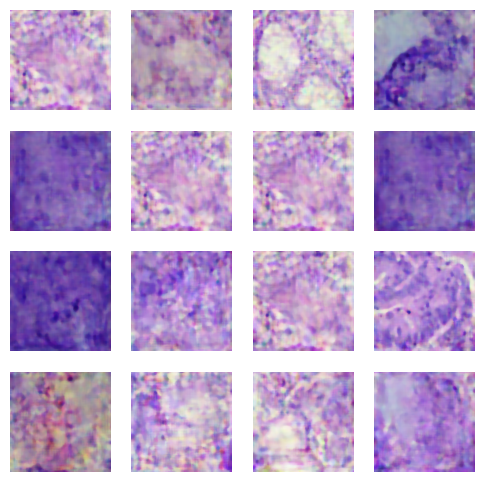

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

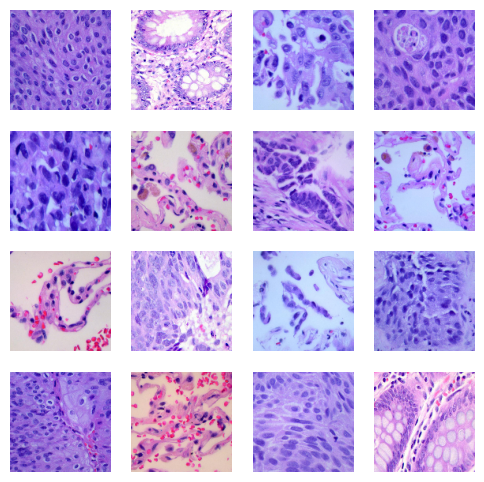

| It: 1 | Loss: -12.1679 | Time:   0.34s |


| It: 1001 | Loss: -60.5981 | Time: 349.16s |


| It: 2001 | Loss: -61.2853 | Time: 352.42s |


| It: 3001 | Loss: -61.4811 | Time: 352.11s |


| It: 4001 | Loss: -61.6075 | Time: 351.60s |


| It: 5001 | Loss: -61.6793 | Time: 350.19s |


| It: 6001 | Loss: -61.7317 | Time: 345.15s |


| It: 7001 | Loss: -61.7723 | Time: 352.52s |


| It: 8001 | Loss: -61.7978 | Time: 356.80s |


| It: 9001 | Loss: -61.8105 | Time: 353.88s |


| It: 1 | Loss: -12.9624 | Time:   0.32s |


| It: 1001 | Loss: -60.9973 | Time: 350.29s |


| It: 2001 | Loss: -61.5574 | Time: 352.27s |


| It: 3001 | Loss: -61.6920 | Time: 350.90s |


| It: 4001 | Loss: -61.7594 | Time: 354.69s |


| It: 5001 | Loss: -61.8044 | Time: 349.94s |


| It: 6001 | Loss: -61.8395 | Time: 349.18s |


| It: 7001 | Loss: -61.8647 | Time: 354.95s |


| It: 8001 | Loss: -61.8817 | Time: 348.05s |


| It: 9001 | Loss: -61.8898 | Time: 345.09s |


| It: 1 | Loss: -15.4874 | Time:   0.38s |


| It: 1001 | Loss: -60.4253 | Time: 351.80s |


| It: 2001 | Loss: -61.3493 | Time: 349.76s |


| It: 3001 | Loss: -61.6081 | Time: 347.96s |


| It: 4001 | Loss: -61.7102 | Time: 348.78s |


| It: 5001 | Loss: -61.7686 | Time: 351.32s |


| It: 6001 | Loss: -61.8171 | Time: 345.83s |


| It: 7001 | Loss: -61.8487 | Time: 351.20s |


| It: 8001 | Loss: -61.8683 | Time: 341.07s |


| It: 9001 | Loss: -61.8786 | Time: 348.00s |


| It: 1 | Loss: -27.5818 | Time:   0.35s |


| It: 1001 | Loss: -60.5116 | Time: 350.06s |


| It: 2001 | Loss: -61.3051 | Time: 349.19s |


| It: 3001 | Loss: -61.5015 | Time: 347.11s |


| It: 4001 | Loss: -61.6468 | Time: 340.87s |


| It: 5001 | Loss: -61.7392 | Time: 350.14s |


| It: 6001 | Loss: -61.7962 | Time: 351.50s |


| It: 7001 | Loss: -61.8365 | Time: 347.35s |


| It: 8001 | Loss: -61.8588 | Time: 348.54s |


| It: 9001 | Loss: -61.8711 | Time: 347.64s |


| It: 1 | Loss: -21.2394 | Time:   0.38s |


| It: 1001 | Loss: -60.8131 | Time: 344.19s |


| It: 2001 | Loss: -61.4230 | Time: 350.68s |


| It: 3001 | Loss: -61.6475 | Time: 351.00s |


| It: 4001 | Loss: -61.7371 | Time: 349.19s |


| It: 5001 | Loss: -61.7889 | Time: 349.75s |


| It: 6001 | Loss: -61.8306 | Time: 350.38s |


| It: 7001 | Loss: -61.8590 | Time: 347.76s |


| It: 8001 | Loss: -61.8769 | Time: 351.61s |


| It: 9001 | Loss: -61.8854 | Time: 350.97s |


BEST PSNR: 13.5433
MEDIAN PSNR: 12.7210
ALL PSNR: [10.8694, 13.5433, 12.9165, 12.9584, 12.9584]


<Figure size 400x300 with 0 Axes>

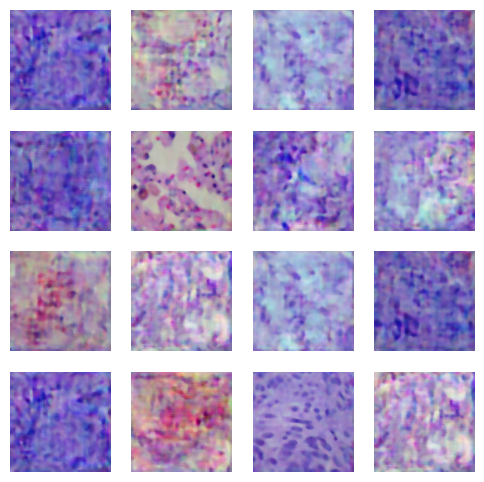

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

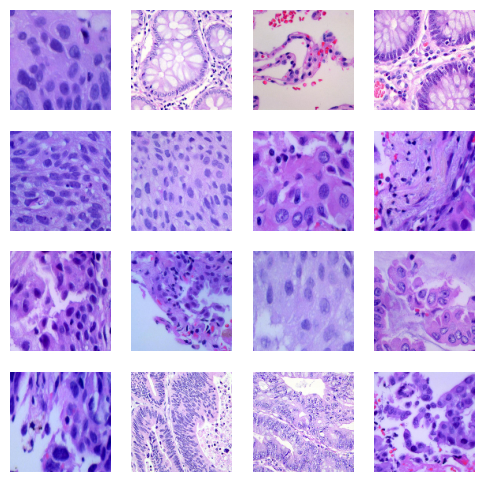

| It: 1 | Loss: -21.3671 | Time:   0.36s |


| It: 1001 | Loss: -60.8276 | Time: 349.08s |


| It: 2001 | Loss: -61.4633 | Time: 345.96s |


| It: 3001 | Loss: -61.6378 | Time: 349.91s |


| It: 4001 | Loss: -61.7293 | Time: 348.96s |


| It: 5001 | Loss: -61.7890 | Time: 350.61s |


| It: 6001 | Loss: -61.8281 | Time: 351.93s |


| It: 7001 | Loss: -61.8591 | Time: 353.13s |


| It: 8001 | Loss: -61.8777 | Time: 350.74s |


| It: 9001 | Loss: -61.8886 | Time: 352.73s |


| It: 1 | Loss: -37.3477 | Time:   0.36s |


| It: 1001 | Loss: -60.4306 | Time: 346.94s |


| It: 2001 | Loss: -61.3315 | Time: 346.65s |


| It: 3001 | Loss: -61.5783 | Time: 361.72s |


| It: 4001 | Loss: -61.6867 | Time: 363.48s |


| It: 5001 | Loss: -61.7577 | Time: 361.96s |


| It: 6001 | Loss: -61.8063 | Time: 361.92s |


| It: 7001 | Loss: -61.8414 | Time: 363.99s |


| It: 8001 | Loss: -61.8650 | Time: 362.42s |


| It: 9001 | Loss: -61.8756 | Time: 364.77s |


| It: 1 | Loss: -4.8949 | Time:   0.38s |


| It: 1001 | Loss: -60.6338 | Time: 357.03s |


| It: 2001 | Loss: -61.3541 | Time: 359.99s |


| It: 3001 | Loss: -61.5633 | Time: 356.51s |


| It: 4001 | Loss: -61.6719 | Time: 358.74s |


| It: 5001 | Loss: -61.7502 | Time: 358.91s |


| It: 6001 | Loss: -61.8004 | Time: 360.80s |


| It: 7001 | Loss: -61.8403 | Time: 353.18s |


| It: 8001 | Loss: -61.8641 | Time: 356.07s |


| It: 9001 | Loss: -61.8762 | Time: 355.07s |


| It: 1 | Loss: -33.1262 | Time:   0.38s |


| It: 1001 | Loss: -61.0695 | Time: 360.59s |


| It: 2001 | Loss: -61.5541 | Time: 360.05s |


| It: 3001 | Loss: -61.6862 | Time: 359.86s |


| It: 4001 | Loss: -61.7622 | Time: 357.49s |


| It: 5001 | Loss: -61.8046 | Time: 360.03s |


| It: 6001 | Loss: -61.8427 | Time: 356.74s |


| It: 7001 | Loss: -61.8699 | Time: 357.43s |


| It: 8001 | Loss: -61.8861 | Time: 354.95s |


| It: 9001 | Loss: -61.8960 | Time: 359.75s |


| It: 1 | Loss: -25.9496 | Time:   0.39s |


| It: 1001 | Loss: -60.7897 | Time: 359.31s |


| It: 2001 | Loss: -61.3801 | Time: 358.16s |


| It: 3001 | Loss: -61.5968 | Time: 357.57s |


| It: 4001 | Loss: -61.7080 | Time: 353.20s |


| It: 5001 | Loss: -61.7723 | Time: 355.29s |


| It: 6001 | Loss: -61.8199 | Time: 352.93s |


| It: 7001 | Loss: -61.8547 | Time: 355.35s |


| It: 8001 | Loss: -61.8771 | Time: 356.40s |


| It: 9001 | Loss: -61.8867 | Time: 358.08s |


BEST PSNR: 13.9686
MEDIAN PSNR: 13.6751
ALL PSNR: [13.9686, 13.7414, 13.7283, 13.8001, 13.8001]


<Figure size 400x300 with 0 Axes>

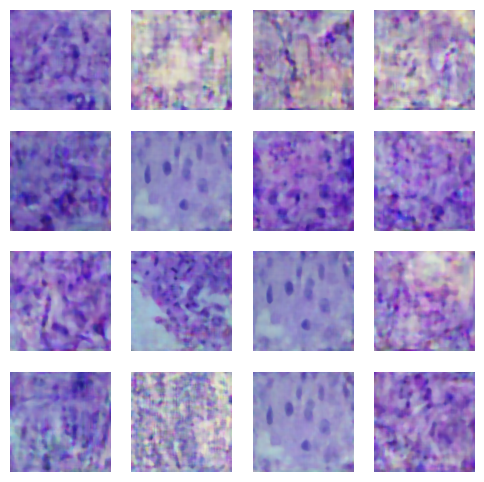

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

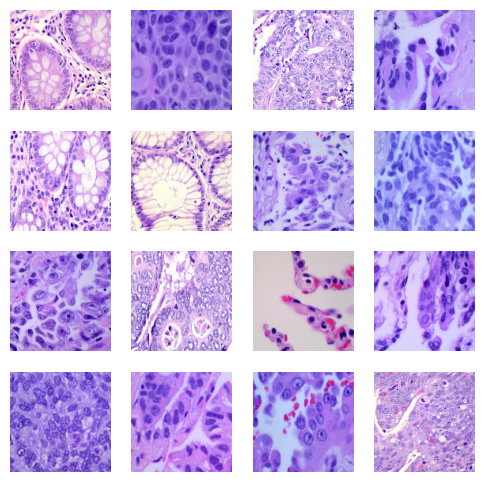

| It: 1 | Loss: -26.6998 | Time:   0.34s |


| It: 1001 | Loss: -61.2680 | Time: 354.49s |


| It: 2001 | Loss: -61.6564 | Time: 359.59s |


| It: 3001 | Loss: -61.7514 | Time: 358.00s |


| It: 4001 | Loss: -61.8037 | Time: 359.78s |


| It: 5001 | Loss: -61.8408 | Time: 357.36s |


| It: 6001 | Loss: -61.8669 | Time: 356.20s |


| It: 7001 | Loss: -61.8882 | Time: 358.47s |


| It: 8001 | Loss: -61.9003 | Time: 357.25s |


| It: 9001 | Loss: -61.9076 | Time: 354.93s |


| It: 1 | Loss: -27.1229 | Time:   0.38s |


| It: 1001 | Loss: -61.1532 | Time: 357.96s |


| It: 2001 | Loss: -61.6315 | Time: 356.65s |


| It: 3001 | Loss: -61.7416 | Time: 359.36s |


| It: 4001 | Loss: -61.8042 | Time: 354.95s |


| It: 5001 | Loss: -61.8407 | Time: 358.00s |


| It: 6001 | Loss: -61.8686 | Time: 356.23s |


| It: 7001 | Loss: -61.8879 | Time: 354.74s |


| It: 8001 | Loss: -61.9012 | Time: 359.08s |


| It: 9001 | Loss: -61.9081 | Time: 358.24s |


| It: 1 | Loss: -19.8579 | Time:   0.42s |


| It: 1001 | Loss: -61.4101 | Time: 358.36s |


| It: 2001 | Loss: -61.6990 | Time: 359.29s |


| It: 3001 | Loss: -61.7682 | Time: 358.70s |


| It: 4001 | Loss: -61.8231 | Time: 358.87s |


| It: 5001 | Loss: -61.8527 | Time: 358.39s |


| It: 6001 | Loss: -61.8772 | Time: 358.38s |


| It: 7001 | Loss: -61.8985 | Time: 358.01s |


| It: 8001 | Loss: -61.9105 | Time: 359.05s |


| It: 9001 | Loss: -61.9163 | Time: 354.26s |


| It: 1 | Loss: -28.9822 | Time:   0.39s |


| It: 1001 | Loss: -61.4155 | Time: 358.10s |


| It: 2001 | Loss: -61.6827 | Time: 356.33s |


| It: 3001 | Loss: -61.7749 | Time: 352.19s |


| It: 4001 | Loss: -61.8163 | Time: 358.79s |


| It: 5001 | Loss: -61.8541 | Time: 357.94s |


| It: 6001 | Loss: -61.8779 | Time: 356.84s |


| It: 7001 | Loss: -61.8971 | Time: 359.30s |


| It: 8001 | Loss: -61.9099 | Time: 358.24s |


| It: 9001 | Loss: -61.9163 | Time: 357.75s |


| It: 1 | Loss: -21.2552 | Time:   0.39s |


| It: 1001 | Loss: -61.4239 | Time: 358.85s |


| It: 2001 | Loss: -61.6944 | Time: 361.11s |


| It: 3001 | Loss: -61.7700 | Time: 357.49s |


| It: 4001 | Loss: -61.8204 | Time: 358.96s |


| It: 5001 | Loss: -61.8530 | Time: 355.69s |


| It: 6001 | Loss: -61.8775 | Time: 357.89s |


| It: 7001 | Loss: -61.8963 | Time: 359.07s |


| It: 8001 | Loss: -61.9080 | Time: 353.54s |


| It: 9001 | Loss: -61.9143 | Time: 359.07s |


BEST PSNR: 14.4581
MEDIAN PSNR: 14.1637
ALL PSNR: [14.0402, 13.8428, 14.4581, 14.0460, 14.0460]


<Figure size 400x300 with 0 Axes>

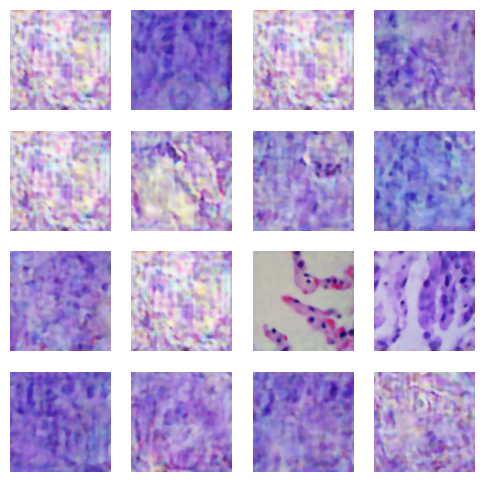

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)